In [1]:
%cd /content/drive/MyDrive/behavox/

/content/drive/MyDrive/behavox


In [2]:
!pip install transformers

     |████████████████████████████████| 2.3MB 34.8MB/s 
     |████████████████████████████████| 901kB 45.0MB/s 
     |████████████████████████████████| 3.3MB 46.0MB/s 


In [3]:
import pandas as pd
from transformers import BertTokenizer
import collections
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import seaborn as sns
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
% matplotlib inline

In [4]:
def check_gpu_availabilty():
  if torch.cuda.is_available():        
      device = torch.device("cuda")
      print('There are %d GPU(s) available.' % torch.cuda.device_count())
      print('We will use the GPU:', torch.cuda.get_device_name(0))
  else:
      print('No GPU available, using the CPU instead.')
      device = torch.device("cpu")
  return device

def read_train_test(train_file_name, test_file_name):
  train_df = pd.read_csv(f'dataset/{train_file_name}.csv')
  test_df = pd.read_csv(f'dataset/{test_file_name}.csv')
  return train_df,test_df

def get_sents_from_df(df,sent_column):
  return df[sent_column].values

def get_labels_from_df(df,label_column):
  return df[label_column].values

def get_labels_map(df):
    labels = sorted(df['label'].unique().tolist())
    label2id = collections.OrderedDict(zip(labels, range(len(labels))))
    return label2id

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def get_tokenizer(pre_trained_model):
  print('Loading  tokenizer...')
  tokenizer = BertTokenizer.from_pretrained(pre_trained_model, do_lower_case=True)
  return tokenizer

def get_max_len(sentences):
  max_len = 0
  for sent in sentences:
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      max_len = max(max_len, len(input_ids))
  return max_len

def encode_data(tokenizer, sentences, labels, max_len):
  input_ids = []
  attention_masks = []

  for sent in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sent,
                          add_special_tokens = True,
                          max_length = max_len,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt',
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

def get_train_test_split(input_ids, attention_masks, labels, split_size = 0.9):
  dataset = TensorDataset(input_ids, attention_masks, labels)
  train_size = int(split_size * len(dataset))
  val_size = len(dataset) - train_size
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
  return train_dataset, val_dataset

def create_dataloader(dataset, batch_size, Sampler):
  dataloader = DataLoader(
            dataset,
            sampler = Sampler(dataset),
            batch_size = batch_size
        )
  return dataloader

def build_model(task, pre_trained_model, classes, epochs=30, lr=2e-5, eps=1e-8, num_warmup_steps = 0):
  model = task.from_pretrained(
      pre_trained_model,
      num_labels = len(classes),
      output_attentions = False,
      output_hidden_states = False,
  )
  model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = eps
                )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = total_steps)
  
  return model, optimizer, scheduler

def train_model(seed_val, epochs, model, train_dataloader, validation_dataloader, device):
  seed_val = 42
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []
  total_t0 = time.time()

  for epoch_i in range(0, epochs):
      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_train_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model.zero_grad()
          result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)
          loss = result.loss
          logits = result.logits
          total_train_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

      avg_train_loss = total_train_loss / len(train_dataloader)
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
      print("")
      print("Running Validation...")

      t0 = time.time()
      model.eval()
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      for batch in validation_dataloader:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          with torch.no_grad():
              result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)
          loss = result.loss
          logits = result.logits
          total_eval_loss += loss.item()
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          total_eval_accuracy += flat_accuracy(logits, label_ids)

      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      avg_val_loss = total_eval_loss / len(validation_dataloader)

      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, training_stats

def predict(model, prediction_dataloader, device):
  model.eval() 
  predictions , top_pred, true_labels = [], [], []
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
    logits = result.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    top_pred.extend(np.argmax(softmax(logits, axis=1),axis=1))
    true_labels.extend(label_ids)
    predictions.extend(softmax(logits, axis=1))
  return top_pred, true_labels, predictions

def get_cr_cm(gt,pred):
    print(classification_report(gt,pred))
    # print(confusion_matrix(gt,pred))
    gt_series = pd.Series(gt)
    pred_series = pd.Series(pred)
    cm = pd.crosstab(gt_series, pred_series, rownames=['TRUE'], colnames=['PREDICTED'],margins=True)
    return cm

Execute the code

In [5]:
device = check_gpu_availabilty()
print('\n')

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
test_df = df[~msk]

train_sents = get_sents_from_df(train_df,"sentence")
train_labels = get_labels_from_df(train_df, "label")
print("Number of training examples sentences : ", len(train_sents))
print("Number of training labels : ", len(train_labels))
print('\n')

test_sents = get_sents_from_df(test_df,"sentence")
test_labels = get_labels_from_df(test_df, "label")
print("Number of test examples sentences : ", len(test_sents))
print("Number of test labels : ", len(test_labels))
print('\n')

pre_trained_model = "bert-base-uncased"
tokenizer = get_tokenizer(pre_trained_model)

label2id = get_labels_map(train_df)
classes = list(label2id.keys())
labels = [label2id[l] for l in train_labels]
print("Number of unique classes in training data : ", len(classes))
print('\n')

max_len = get_max_len(train_sents)
print('Max sentence length in training data: ', max_len)

max_len = 64
input_ids, attention_masks, labels = encode_data(tokenizer, train_sents, labels, max_len)

split_size = 0.9
train_dataset, val_dataset = get_train_test_split(input_ids, attention_masks, labels, split_size = split_size)
print("Training data set shape : ", len(train_dataset))
print("Validation data set shape : ", len(val_dataset))

batch_size = 32
train_dataloader = create_dataloader(train_dataset, batch_size, RandomSampler)
validation_dataloader = create_dataloader(val_dataset, batch_size, SequentialSampler)

epochs = 10
lr = 2e-5
eps = 1e-8
num_warmup_steps = 0
model, optimizer, scheduler = build_model(BertForSequenceClassification, pre_trained_model, classes, epochs=epochs, lr=lr, eps=eps, num_warmup_steps=num_warmup_steps )

seed_val = 42
model,training_stats = train_model(seed_val, epochs, model, train_dataloader, validation_dataloader, device)

test_labels = [label2id[l] for l in test_labels]
id2label = dict((v,k) for k,v in label2id.items())

input_ids, attention_masks, labels = encode_data(tokenizer, test_sents, test_labels, max_len)

prediction_dataloader = create_dataloader(TensorDataset(input_ids, attention_masks, labels), batch_size, SequentialSampler)
top_pred, true_labels, predictions = predict(model, prediction_dataloader, device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Number of training examples sentences :  7692
Number of training labels :  7692


Number of test examples sentences :  859
Number of test labels :  859


Loading  tokenizer...



Number of unique classes in training data :  2




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length in training data:  47


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training data set shape :  6922
Validation data set shape :  770


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    217.    Elapsed: 0:00:14.
  Batch    80  of    217.    Elapsed: 0:00:29.
  Batch   120  of    217.    Elapsed: 0:00:44.
  Batch   160  of    217.    Elapsed: 0:00:59.
  Batch   200  of    217.    Elapsed: 0:01:13.

  Average training loss: 0.51
  Training epcoh took: 0:01:19

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.46
  Validation took: 0:00:03

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    217.    Elapsed: 0:00:14.
  Batch    80  of    217.    Elapsed: 0:00:29.
  Batch   120  of    217.    Elapsed: 0:00:44.
  Batch   160  of    217.    Elapsed: 0:00:58.
  Batch   200  of    217.    Elapsed: 0:01:13.

  Average training loss: 0.33
  Training epcoh took: 0:01:19

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.50
  Validation took: 0:00:03

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    217.    Elapsed: 0:00:15.
  Batch    80  of    217.    Elapsed: 0:00:29

In [6]:
model.save_pretrained('bert_finetuned_cola_model/')
tokenizer.save_pretrained('bert_finetuned_cola_model/')

('bert_finetuned_cola_model/tokenizer_config.json',
 'bert_finetuned_cola_model/special_tokens_map.json',
 'bert_finetuned_cola_model/vocab.txt',
 'bert_finetuned_cola_model/added_tokens.json')

In [13]:
new_tokenizer = tokenizer.from_pretrained('bert_finetuned_cola_model/')
new_model = BertForSequenceClassification.from_pretrained('bert_finetuned_cola_model/')

Training Stats

       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1            0.51527      0.43061        0.81125       0:01:10         0:00:03
2            0.34152      0.46701        0.81500       0:01:14         0:00:03


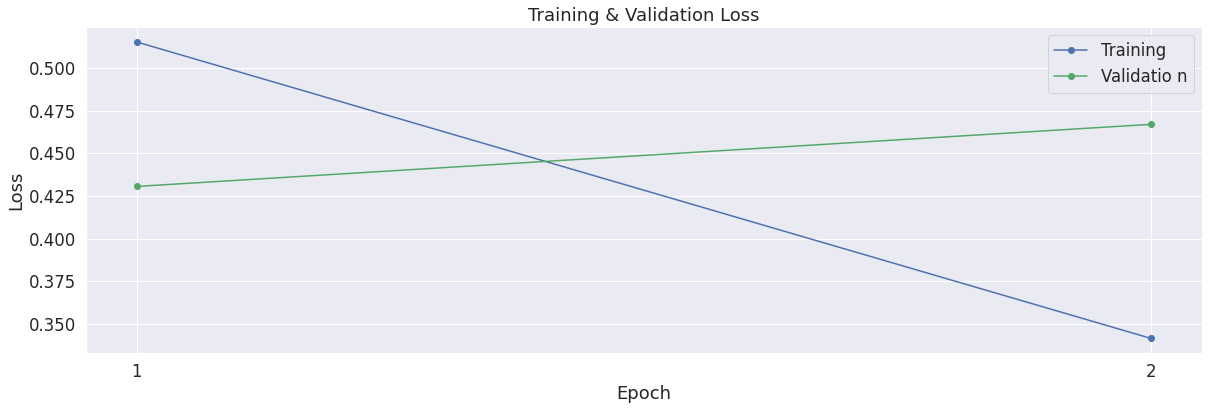

In [9]:
pd.set_option('precision', 5)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
print(df_stats)

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validatio n")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(1,epochs+1)])
plt.show()

Performance on Test Set

In [ ]:
out_df = test_df.rename(columns={'text':'sentence','labels':'label'})
out_df['predicted_node'] = [id2label[top_pred[i]] for i in range(len(test_df))]
out_df['predicted_node_score'] = [predictions[i][top_pred[i]] for i in range(len(test_df))]
# out_df.to_csv(f'preds/bert_sofmattressexp1.csv', columns=['sentence', 'label', 'predicted_node', 'predicted_node_score'], index=False)
print(out_df.shape)
out_df.head(10)

(847, 6)


sentence_source  label  ... predicted_node predicted_node_score
15             gj04      1  ...              1              0.99977
42             gj04      0  ...              0              0.99903
60             gj04      1  ...              1              0.99899
61             gj04      0  ...              1              0.78879
64             gj04      1  ...              1              0.99973
65             gj04      0  ...              1              0.99465
69             gj04      1  ...              0              0.57134
119            cj99      1  ...              1              0.99954
145            cj99      0  ...              0              0.99900
149            cj99      1  ...              1              0.99941

[10 rows x 6 columns]

Classification report and confusion matrix

In [ ]:
get_cr_cm(out_df['label'],out_df['predicted_node'])

              precision    recall  f1-score   support

           0       0.78      0.59      0.67       244
           1       0.85      0.93      0.89       603

    accuracy                           0.83       847
   macro avg       0.81      0.76      0.78       847
weighted avg       0.83      0.83      0.83       847



PREDICTED    0    1  All
TRUE                    
0          145   99  244
1           41  562  603
All        186  661  847

Missclassifed test docs

In [ ]:
out_df[out_df['label']!=out_df['predicted_node']].iloc[20:30].values

array([['bc01', 1, nan, 'We rich have impeccable taste.', 0,
        0.9974240660667419],
       ['r-67', 1, nan,
        'I believed the claim that Otto was wearing this hat.', 0,
        0.6056921482086182],
       ['r-67', 0, '*',
        "I have Tom's feeling that the company will squander the money.",
        1, 0.999674379825592],
       ['r-67', 0, '*', 'I know a man who hates myself.', 1,
        0.999293327331543],
       ['r-67', 0, '*',
        'The excellent whisky which I went to the store and have bought was very costly.',
        1, 0.9971694946289062],
       ['r-67', 1, nan,
        'Although Bob may not be a nut, many people have claimed it and I think so too.',
        0, 0.9976480603218079],
       ['r-67', 0, '*', 'Make yourself comfortable and I got sick.', 1,
        0.9990703463554382],
       ['r-67', 0, '*',
        "The boy whose guardian's we elected employer president betrayed us.",
        1, 0.9953387975692749],
       ['r-67', 0, '*', 'How tall did Sheil